# 01 — Data Exploration 
- Tải `AB_NYC_2019.csv` (nếu chưa có) bằng Kaggle CLI
- Đọc CSV *không dùng pandas* (chỉ csv + numpy) qua `src.data_processing`
- In report: shape, cột quan trọng, unique của nhóm/kind, NA, phạm vi availability_365

In [1]:
# thêm project root (thư mục chứa 'src/') vào sys.path
from pathlib import Path
import sys

ROOT = Path.cwd()
while not (ROOT / "src").is_dir() and ROOT.parent != ROOT:
    ROOT = ROOT.parent

sys.path.append(str(ROOT))

## 1. Tải & kiểm tra dữ liệu

In [2]:
from src.data_processing import load_and_check 

report = load_and_check(root=str(ROOT / "data"))

Shape: 48895 hang x 16 cot
Important Columns: price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count, availability_365, latitude, longitude
neighbourhood_group: 5 groups -> Bronx, Brooklyn, Manhattan, Queens
room_type: 3 types -> Entire home/apt, Private room, Shared room
availability_365 out of [0, 365]: 0
reviews_per_month NA: 10052
last_review NA: 10052


## 2. Đọc dữ liệu bằng NumPy

In [3]:
from src.data_processing import ensure_data_dirs, load_airbnb_numpy

# Lấy đường dẫn CSV và load thành dict {'header', 'text', 'num'}
dirs = ensure_data_dirs(root=str(ROOT / "data"))
csv_path = dirs["raw"] / "AB_NYC_2019.csv"

data = load_airbnb_numpy(csv_path)
header = data["header"]
num = data["num"]   
text = data["text"] 

print("Số cột:", len(header))
print("Các cột số có:", list(num.keys()))
print("Các cột text có:", list(text.keys())[:8], "...")

Số cột: 16
Các cột số có: ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
Các cột text có: ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type', 'last_review'] ...


## 3. Thống kê mô tả

In [4]:
import numpy as np

# Hàm mô tả cột số, bỏ qua NaN bằng np.nan* (ổn định và gọn)
def describe_numeric(arr: np.ndarray) -> dict:
    # arr có thể chứa NaN (đặc biệt reviews_per_month)
    return {
        "n": int(arr.size),
        "missing": int(np.isnan(arr).sum()) if arr.dtype.kind in "fc" else 0,
        "mean": float(np.nanmean(arr)),
        "std": float(np.nanstd(arr)),
        "min": float(np.nanmin(arr)),
        "p25": float(np.nanpercentile(arr, 25)),
        "p50": float(np.nanmedian(arr)),
        "p75": float(np.nanpercentile(arr, 75)),
        "max": float(np.nanmax(arr)),
    }

# Các cột số chính để mô tả
KEY_NUM_COLS = [
    "price",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
    "latitude",
    "longitude",
]

desc = {}
for col in KEY_NUM_COLS:
    if col in num:
        desc[col] = describe_numeric(num[col])

# In gọn kết quả
for k, v in desc.items():
    print(f"[{k}] n={v['n']} miss={v['missing']} | "
          f"mean={v['mean']:.2f} std={v['std']:.2f} | "
          f"min={v['min']:.2f} p25={v['p25']:.2f} p50={v['p50']:.2f} "
          f"p75={v['p75']:.2f} max={v['max']:.2f}")


[price] n=48895 miss=0 | mean=152.72 std=240.15 | min=0.00 p25=69.00 p50=106.00 p75=175.00 max=10000.00
[minimum_nights] n=48895 miss=0 | mean=7.03 std=20.51 | min=1.00 p25=1.00 p50=3.00 p75=5.00 max=1250.00
[number_of_reviews] n=48895 miss=0 | mean=23.27 std=44.55 | min=0.00 p25=1.00 p50=5.00 p75=24.00 max=629.00
[reviews_per_month] n=48895 miss=10052 | mean=1.37 std=1.68 | min=0.01 p25=0.19 p50=0.72 p75=2.02 max=58.50
[calculated_host_listings_count] n=48895 miss=0 | mean=7.14 std=32.95 | min=1.00 p25=1.00 p50=1.00 p75=2.00 max=327.00
[availability_365] n=48895 miss=0 | mean=112.78 std=131.62 | min=0.00 p25=0.00 p50=45.00 p75=227.00 max=365.00
[latitude] n=48895 miss=0 | mean=40.73 std=0.05 | min=40.50 p25=40.69 p50=40.72 p75=40.76 max=40.91
[longitude] n=48895 miss=0 | mean=-73.95 std=0.05 | min=-74.24 p25=-73.98 p50=-73.96 p75=-73.94 max=-73.71


## 4. Thống kê nhanh cho cột phân loại

In [5]:
def top_counts(arr: np.ndarray, topk: int = 10):
    # Đếm tần suất bằng np.unique(return_counts=True), không dùng pandas
    vals, cnts = np.unique(arr, return_counts=True)
    order = np.argsort(-cnts)  # tần suất giảm dần
    vals, cnts = vals[order], cnts[order]
    k = min(topk, vals.size)
    return list(zip(vals[:k].tolist(), cnts[:k].tolist()))

cat_cols = ["neighbourhood_group", "room_type", "neighbourhood"]
for c in cat_cols:
    if c in text:
        print(f"\nTop {c}:")
        for v, ct in top_counts(text[c], topk=8):
            print(f"  {v}: {ct}")



Top neighbourhood_group:
  Manhattan: 21661
  Brooklyn: 20104
  Queens: 5666
  Bronx: 1091
  Staten Island: 373

Top room_type:
  Entire home/apt: 25409
  Private room: 22326
  Shared room: 1160

Top neighbourhood:
  Williamsburg: 3920
  Bedford-Stuyvesant: 3714
  Harlem: 2658
  Bushwick: 2465
  Upper West Side: 1971
  Hell's Kitchen: 1958
  East Village: 1853
  Upper East Side: 1798


## 5. Plot

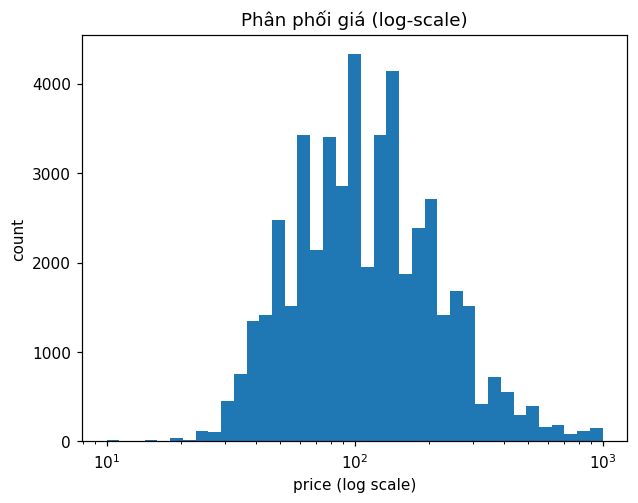

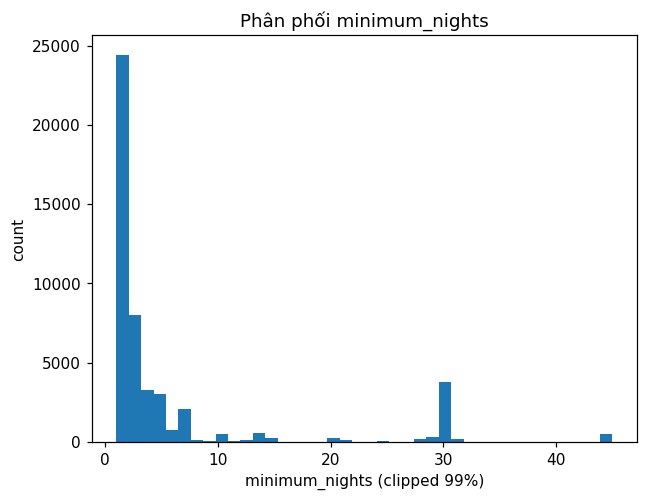

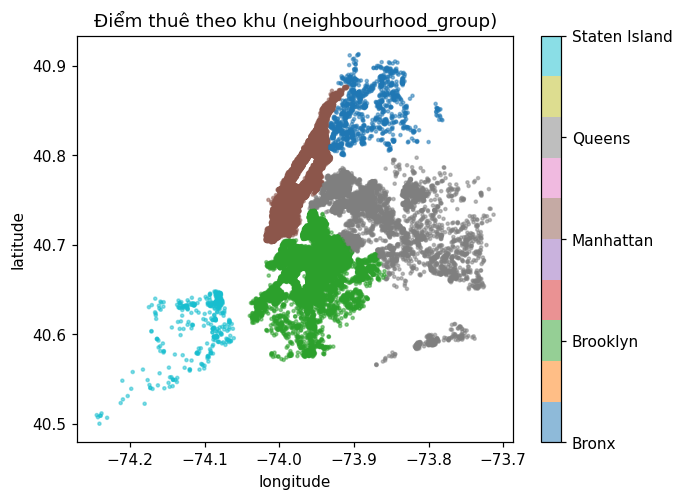

In [6]:
from matplotlib import pyplot as plt

# Thiết lập style đơn giản
plt.rcParams["figure.dpi"] = 110

# 5.1 Histogram giá (log-scale cho trục x để nhìn đuôi dài)
if "price" in num:
    price = num["price"]
    price = price[np.isfinite(price) & (price > 0)]
    plt.figure()
    bins = np.logspace(np.log10(price.min()), np.log10(np.percentile(price, 99.5)), 40)
    plt.hist(price, bins=bins, edgecolor="none")
    plt.xscale("log")
    plt.xlabel("price (log scale)")
    plt.ylabel("count")
    plt.title("Phân phối giá (log-scale)")
    plt.show()

# 5.2 Histogram minimum_nights (clip 99% để tránh outlier phá hình)
if "minimum_nights" in num:
    mn = num["minimum_nights"]
    mn = mn[np.isfinite(mn)]
    clip = np.percentile(mn, 99)
    plt.figure()
    plt.hist(np.clip(mn, a_min=None, a_max=clip), bins=40, edgecolor="none")
    plt.xlabel("minimum_nights (clipped 99%)")
    plt.ylabel("count")
    plt.title("Phân phối minimum_nights")
    plt.show()

# 5.3 Scatter "bản đồ thô": longitude vs latitude, màu = neighbourhood_group
if {"longitude", "latitude"}.issubset(num.keys()) and "neighbourhood_group" in text:
    lon = num["longitude"]; lat = num["latitude"]
    ng = text["neighbourhood_group"]
    ok = np.isfinite(lon) & np.isfinite(lat)
    lon, lat, ng = lon[ok], lat[ok], ng[ok]

    groups, inv = np.unique(ng, return_inverse=True)  # mã hoá nhóm -> [0..G-1]
    plt.figure()
    sc = plt.scatter(lon, lat, c=inv, s=4, alpha=0.5, cmap="tab10")
    plt.xlabel("longitude"); plt.ylabel("latitude")
    plt.title("Điểm thuê theo khu (neighbourhood_group)")
    # chú thích màu nhóm
    cbar = plt.colorbar(sc, ticks=np.arange(groups.size))
    cbar.ax.set_yticklabels(groups.tolist())
    plt.show()
